In [110]:
%load_ext autoreload
%autoreload 2

import scipy
import numpy as np
import matplotlib.pyplot as plt
import keras
# use torch backend
import torch

import time



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
# Distribution Settings
scale = 1
mean = 0

normal_dist = scipy.stats.norm(loc=mean, scale=scale)

# Number of independent datapoints 
T = 1000

seed=360
rng = np.random.RandomState(seed)
y_T = torch.Tensor(normal_dist.rvs(size=T, random_state=rng))
y_T.requires_grad_(True)
# supress cell output
''''''

''

In [127]:
M = 10000

start = time.time()

vals, losses, anal_grad_theta, numer_grad_theta, anal_grad_L, numer_grad_L, anal_grad, numer_grad = [], [], [], [], [], [], [], []

for param_value in np.linspace(-5, 5, 11, dtype=np.float32):

    param = torch.tensor([param_value], requires_grad=True)
    print(param_value)

    for trial in range(10):
        print(trial)

        # Get some samples from the implied distribution
        param_sized = param*torch.ones(T)
        distribution = torch.distributions.Normal(loc=param_sized, scale=1)
        samples_MT = distribution.sample(sample_shape=(M,))

        # calculate the log prob of those samples
        # log probs cannot be an argument, must be "baked" into function
        def get_log_probs_baked(param):
            param_sized = param*torch.ones(T)
            distribution = torch.distributions.Normal(loc=param_sized, scale=1)
            log_probs_MT = distribution.log_prob(samples_MT)

            return log_probs_MT
        
        analytical_grad_theta_wrt_phi_MT = (samples_MT -param)*samples_MT
        jac_log_prob_MT = torch.autograd.functional.jacobian(get_log_probs_baked, (param), strategy='forward-mode', vectorize=True)
        autodiff_grad_theta_wrt_phi_MT = jac_log_prob_MT * torch.unsqueeze(samples_MT, dim=-1)
        analytical_grad_theta_wrt_phi_T = torch.mean(analytical_grad_theta_wrt_phi_MT, dim=0)
        autodiff_grad_theta_wrt_phi_T = torch.mean(autodiff_grad_theta_wrt_phi_MT, dim=0)

        action_samples_MT = distribution.sample(sample_shape=(M,))
        expected_action_T = torch.mean(action_samples_MT, dim=0)
        expected_action_T.requires_grad_(True)
        # ge
        loss_T = torch.nn.functional.mse_loss(expected_action_T, y_T)
        analytical_grad_L_wrt_theta_T = -2.0*(y_T - expected_action_T)
        loss_T.backward()
        autodiff_grad_L_wrt_theta_T = expected_action_T.grad

        analytical_grad_T = analytical_grad_theta_wrt_phi_T * torch.unsqueeze(analytical_grad_L_wrt_theta_T, 1)
        autodiff_grad_T = autodiff_grad_theta_wrt_phi_T * torch.unsqueeze(autodiff_grad_L_wrt_theta_T, 1)

        vals.append(param_value)
        losses.append(loss_T.detach().numpy())
        anal_grad_theta.append(analytical_grad_theta_wrt_phi_T.detach().numpy())
        numer_grad_theta.append(autodiff_grad_theta_wrt_phi_T.detach().numpy())
        anal_grad_L.append(analytical_grad_L_wrt_theta_T.detach().numpy())
        numer_grad_L.append(autodiff_grad_L_wrt_theta_T.detach().numpy())
        anal_grad.append(analytical_grad_T.detach().numpy())
        numer_grad.append(autodiff_grad_T.detach().numpy())

end = time.time()
elapsed = end - start

-5.0
0
1
2
3
4
5
6
7
8
9
-4.0
0
1
2
3
4
5
6
7
8
9
-3.0
0
1
2
3
4
5
6
7
8
9
-2.0
0
1
2
3
4
5
6
7
8
9
-1.0
0
1
2
3
4
5
6
7
8
9
0.0
0
1
2
3
4
5
6
7
8
9
1.0
0
1
2
3
4
5
6
7
8
9
2.0
0
1
2
3
4
5
6
7
8
9
3.0
0
1
2
3
4
5
6
7
8
9
4.0
0
1
2
3
4
5
6
7
8
9
5.0
0
1
2
3
4
5
6
7
8
9


In [91]:
samples_MT.shape

torch.Size([2, 1000])

In [83]:
autodiff_grad_L_wrt_theta_T

tensor([ 9.6587,  9.7521, 11.5312, 12.5934, 14.3806,  9.0455, 10.3206,  7.2074,
         6.6051, 12.6010,  9.8866, 11.8507,  9.7701,  9.4414, 14.0964, 13.2666,
         9.8604,  7.6613, 15.3826, 10.6139,  3.2078, 10.5448, 12.4267,  9.3954,
        11.9515,  8.8559, 10.2706, 16.5498, 11.6381, 14.4323,  4.7365, 11.6863,
         7.6035,  8.3558, 10.6411, 11.4454, 13.0852,  6.1703, 11.8708,  7.9222,
        10.1475, 12.4448, 16.1996,  9.4026, 13.2487,  7.3714,  6.4764,  8.2087,
        14.8786,  9.2761,  6.8344,  6.1795, 10.5737,  5.5169,  9.7838,  6.9529,
        10.9704,  9.2683,  8.1363, 11.7228, 13.5656, 10.5725, 12.3598, 13.4645,
         5.1667, 10.3011,  8.3425,  8.8415, 12.5835, 14.0407,  9.6579,  9.9625,
         9.7746,  9.1603,  8.1998, 13.4320,  8.0507,  7.6522, 11.4839,  8.3691,
        11.4410,  9.2615, 11.3952,  5.1817, 11.1074, 12.0650,  9.7760,  7.4843,
        10.4145,  7.1848,  8.8767, 11.7122, 11.4757, 10.5324,  8.4120, 11.3209,
         7.0285,  9.7300, 13.6938, 10.71

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{L}$, M=2,time: 0.28s')

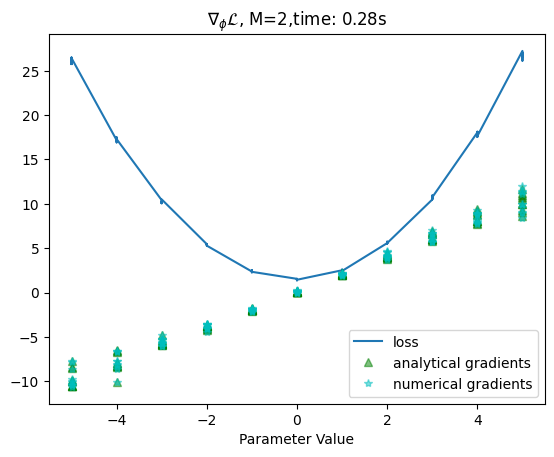

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'c*',alpha=0.5, label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\phi \\mathcal{\\theta}$, M=2,time: 0.28s')

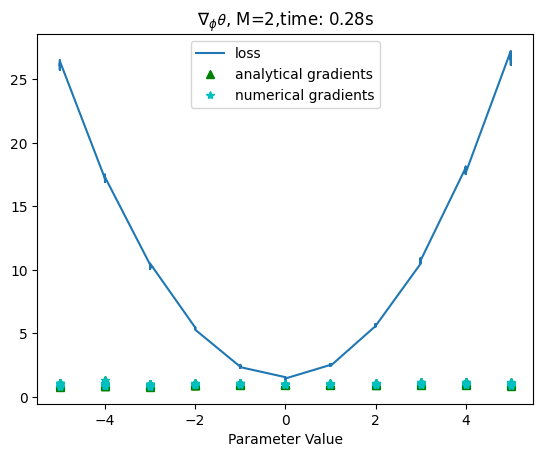

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_theta], 'g^', label='analytical gradients')
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_theta], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{\theta}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\theta \\mathcal{L}$, M=2,time: 0.28s')

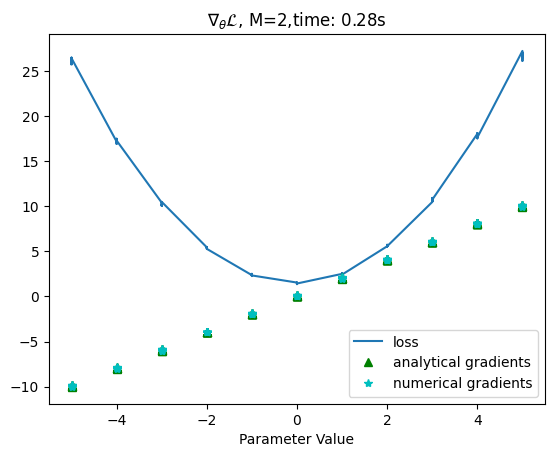

In [ ]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\theta \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

Text(0.5, 1.0, '$\\nabla_\\theta \\mathcal{L}$, M=10000,time: 55.68s')

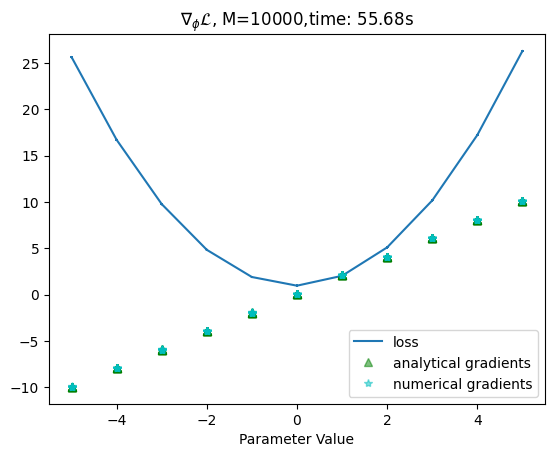

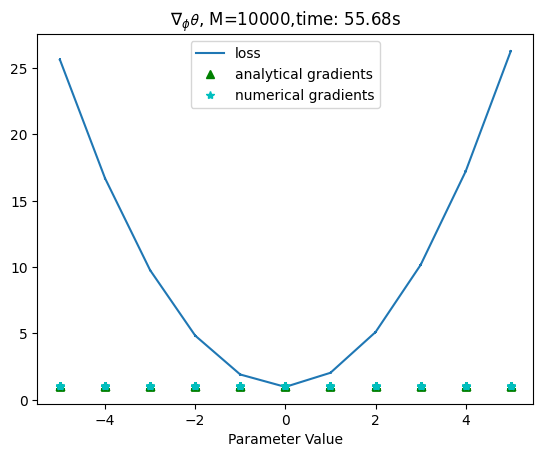

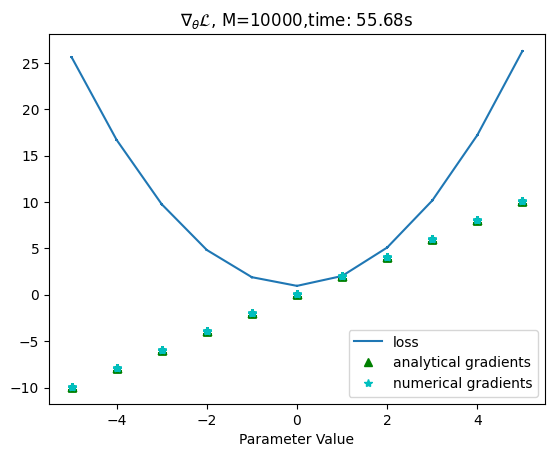

In [128]:
fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad], 'g^',alpha=0.5, label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad], 'c*',alpha=0.5, label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_theta], 'g^', label='analytical gradients')
ax1.plot(vals, [np.mean(grad) for grad in numer_grad_theta], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\phi \mathcal{\theta}$, '+f'M={M},time: {elapsed:.2f}s')

fig, ax1 = plt.subplots()
ax1.set_xlabel('Parameter Value')
ax1.plot(vals, losses, label='loss')

ax1.plot(vals, [np.mean(grad) for grad in anal_grad_L], 'g^', label='analytical gradients')
ax1.plot(vals, [np.sum(grad) for grad in numer_grad_L], 'c*', label='numerical gradients')
plt.legend()
plt.title(r'$\nabla_\theta \mathcal{L}$, '+f'M={M},time: {elapsed:.2f}s')


In [50]:
[np.mean(grad) for grad in numer_grad]

[0.00018617946,
 -0.00027258732,
 -5.2011237e-06,
 0.00018365102,
 0.000123873,
 0.00013241598,
 -2.3332432e-05,
 0.000257431,
 0.0005547508,
 2.5422756e-05,
 5.502917e-05,
 4.058681e-05,
 -8.9222354e-05,
 4.7139165e-05,
 -8.102873e-05,
 -0.00038875663,
 0.00058035814,
 -0.000119333075,
 0.0001392584,
 8.97855e-05,
 4.1955376e-05,
 -0.00018266427,
 -4.806988e-05,
 2.6495443e-05,
 -7.832831e-05,
 -0.0001801407,
 -3.772761e-05,
 -5.5536686e-05,
 8.851932e-05,
 3.5748806e-05,
 -0.00016392716,
 4.1696196e-05,
 5.5270284e-05,
 6.95133e-05,
 -0.0001422174,
 3.8993287e-05,
 2.7167164e-06,
 9.310095e-05,
 -1.5208155e-05,
 -1.797727e-05,
 -0.00013850893,
 -9.623717e-05,
 -3.123299e-05,
 5.0106577e-05,
 -4.6711626e-05,
 4.157176e-05,
 -3.8398033e-05,
 0.00018139397,
 -1.8739813e-05,
 -9.026251e-05,
 -3.056829e-05,
 -1.7068262e-05,
 -1.4013566e-05,
 3.957633e-05,
 8.110906e-05,
 -7.5455087e-06,
 -2.4022564e-05,
 -4.279674e-05,
 -4.1547206e-05,
 3.330332e-05,
 2.0290267e-05,
 8.44038e-05,
 -5.5854

In [51]:
[np.mean(grad) for grad in numer_grad_theta]

[-0.019893425,
 0.024868539,
 0.00409787,
 -0.017555978,
 -0.011278702,
 -0.0072144833,
 0.005025932,
 -0.018429825,
 -0.058510024,
 0.009745349,
 -0.0074980143,
 -0.013480158,
 0.0074054548,
 0.0022459335,
 0.004421507,
 0.046300508,
 -0.06101053,
 0.014492712,
 -0.009784353,
 -0.014391062,
 -0.0030888782,
 0.028707817,
 0.0029996757,
 -0.003252427,
 0.011040169,
 0.026075587,
 0.011770829,
 0.006976722,
 -0.016736457,
 0.0043304074,
 0.023487004,
 -0.01060179,
 -0.019311331,
 -0.025998836,
 0.035514113,
 0.0009665928,
 0.007890291,
 -0.030522019,
 -0.0038923903,
 -0.008654033,
 0.016917644,
 2.8090477e-05,
 0.024836106,
 -0.0510255,
 0.0026977253,
 -0.022508984,
 0.024374837,
 -0.070717394,
 0.003299064,
 -0.007853807,
 -0.017073784,
 -0.0369885,
 -0.01758736,
 -0.0206553,
 -0.024274934,
 -0.01278419,
 -0.032421265,
 -0.043887947,
 -0.007343233,
 -0.021382317,
 0.014731523,
 0.03125373,
 -0.023854226,
 -0.019992119,
 0.0017599848,
 0.017516369,
 0.0069587673,
 -0.008510141,
 -0.00588